<a href="https://colab.research.google.com/github/cmt5270/Fellowship/blob/main/Technical_Assessment_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Importing and Understanding the Data

In [2]:
install.packages(c("tidyverse", "janitor", "fixest", "modelsummary", "scales", "viridis"))

library(tidyverse)
library(janitor)
library(fixest)
library(scales)
library(broom)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zoo’, ‘Formula’, ‘bayestestR’, ‘datawizard’, ‘snakecase’, ‘numDeriv’, ‘sandwich’, ‘dreamerr’, ‘stringmagic’, ‘checkmate’, ‘insight’, ‘parameters’, ‘performance’, ‘tables’, ‘tinytable’, ‘gridExtra’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘scales’


The follow

In [3]:
schools_panel <- read_csv("schools_panel.csv") |> clean_names()
schools_master <- read_csv("schools_master.csv") |> clean_names()
schools_assignments <- read_csv("schools_assignments.csv") |> clean_names()

Rows: 1000 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): school_id, year, test_score, size, books, training, lunch, ever_bo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (3): school_id, size, fixed_effect

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): school_id, treat_year, books, training, lunch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(schools_panel)
head(schools_master)
head(schools_assignments)

school_id,year,test_score,size,books,training,lunch,ever_books,ever_training,ever_lunch,treat_year,cost_total,cost_per_student
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2016,51.170,7,0,0,0,1,0,1,2019,0,0
0,2017,51.645,7,0,0,0,1,0,1,2019,0,0
0,2018,53.691,7,0,0,0,1,0,1,2019,0,0
0,2019,68.268,7,1,0,1,1,0,1,2019,875,125
0,2020,71.966,7,1,0,1,1,0,1,2019,0,0
0,2021,72.751,7,1,0,1,1,0,1,2019,0,0


school_id,size,fixed_effect
<dbl>,<dbl>,<dbl>
0,220,-2.942293
1,1087,10.303402
2,531,7.361847
3,439,4.616830
4,786,4.335618
5,1400,-2.532764


school_id,treat_year,books,training,lunch
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019,1,0,1
1,2019,0,0,0
2,2019,0,0,1
3,2019,0,1,1
4,2019,1,0,1
5,2019,0,1,0


In [5]:
# Check if (cost_total / size) equals cost_per_student for most rows
# to confirm whether schools_panel$size is a scaling constant

scaling_check_2019 <- schools_panel |>
  filter(year == 2019, !is.na(cost_total), !is.na(cost_per_student)) |>
  mutate(
    ratio = cost_total / cost_per_student,
    difference = ratio - size)

scaling_check_2019 |>
  select(school_id, year, size, cost_total, cost_per_student, ratio, difference) |>
  head(10)

school_id,year,size,cost_total,cost_per_student,ratio,difference
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019,7,875,125,7,0
1,2019,7,0,0,NaN,NaN
2,2019,7,525,75,7,0
3,2019,7,1225,175,7,0
4,2019,7,875,125,7,0
5,2019,7,700,100,7,0
6,2019,7,350,50,7,0
7,2019,7,350,50,7,0
8,2019,7,525,75,7,0


In [6]:
# Confirm whether absolute difference between ratio
# and cost_per_student is effectively zero

scaling_summary_2019 <- scaling_check_2019 |>
  summarise(
    total_rows = n(),
    equal_within_tolerance = sum(abs(ratio - size) < 1e-6, na.rm = TRUE),
    percent_equal = mean(abs(ratio - size) < 1e-6, na.rm = TRUE) * 100)

scaling_summary_2019

# percent_equal = 100 indicates size in schools_panel is a scaling constant

total_rows,equal_within_tolerance,percent_equal
<int>,<int>,<dbl>
100,96,100


### Notes:
- `fixed_effect` : controls for influence of unchaging characteristics specific to each school
-  **schools_assignments** and ** school_panel** contain overlapping data for intervention(s)implemented in the year 2019 at each school
  - **schools_panel** also contains data on interventions in prior and later years
- `ever_books`, `ever_lunch`, and `ever_training` also tell us whether these interventions were implemented in 2019
  - does not provide date on implementation of interventions prior to or after 2019
- the variable *size* in **schools_panel** is a scaling constant to to calculate `cost_per_student` from `cost_total`
- the variable *size* in **schools_master** more likely reflects actual enrollment numbers for the year 2019
- treatment-related variables are binary; all others are integers


# Section 1: Exploratory Data Analysis

## 1.1: Merging Datasets

In [7]:
# Keep only columns to check and rename for clarity

assignments_core <- schools_assignments |>
  select(
    school_id,
    books_assign        = books,       # rename to *_assign to distinguish
    training_assign     = training,
    lunch_assign        = lunch,
    treat_year_assign   = treat_year)

panel_core <- schools_panel |>
  select(school_id, year, books, training, lunch)  # panel truth by year

In [8]:
# Compare assignment_core and panel_core to confirm alignment

assign_check <- panel_core |>
  inner_join(assignments_core, by = "school_id") |>
  filter(year == treat_year_assign) |>
  mutate(
    # Ensure comparisons are 0/1 vs 0/1 (not TRUE/FALSE vs 0/1)
    books_match    = (as.integer(books)    == as.integer(books_assign)),
    training_match = (as.integer(training) == as.integer(training_assign)),
    lunch_match    = (as.integer(lunch)    == as.integer(lunch_assign))) |>
  select(
    school_id, year,
    books, books_assign, books_match,
    training, training_assign, training_match,
    lunch, lunch_assign, lunch_match)

assign_check |> head(10)

school_id,year,books,books_assign,books_match,training,training_assign,training_match,lunch,lunch_assign,lunch_match
<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<lgl>
0,2019,1,1,TRUE,0,0,TRUE,1,1,TRUE
1,2019,0,0,TRUE,0,0,TRUE,0,0,TRUE
2,2019,0,0,TRUE,0,0,TRUE,1,1,TRUE
3,2019,0,0,TRUE,1,1,TRUE,1,1,TRUE
4,2019,1,1,TRUE,0,0,TRUE,1,1,TRUE
5,2019,0,0,TRUE,1,1,TRUE,0,0,TRUE
6,2019,1,1,TRUE,0,0,TRUE,0,0,TRUE
7,2019,1,1,TRUE,0,0,TRUE,0,0,TRUE
8,2019,0,0,TRUE,0,0,TRUE,1,1,TRUE


In [9]:
# Check match rates to ensure 100% alignment
# before excluding schools_assignments
assign_summary <- assign_check |>
  summarise(
    n = n(),
    pct_books_match    = mean(books_match,    na.rm = TRUE) * 100,
    pct_training_match = mean(training_match, na.rm = TRUE) * 100,
    pct_lunch_match    = mean(lunch_match,    na.rm = TRUE) * 100)

assign_summary

n,pct_books_match,pct_training_match,pct_lunch_match
<int>,<dbl>,<dbl>,<dbl>
100,100,100,100


In [10]:
# Merge datasets and create helper variables
schools <- schools_panel |>
  # bring in true baseline size to avoid confusion with scaling constant 'size'
  left_join(schools_master |> rename(enrollment = size), by = "school_id") |>
  mutate(
    # ensure treatments are 0/1 integers for modeling later
    books    = as.integer(books),
    training = as.integer(training),
    lunch    = as.integer(lunch),
    # indicator for whether observation is before or after 2019 intervention
    post_2019 = as.integer(year >= 2019))

head(schools)

schools |> count(year) |> arrange(year)
schools |> count(books, training, lunch) |> arrange(desc(n))

school_id,year,test_score,size,books,training,lunch,ever_books,ever_training,ever_lunch,treat_year,cost_total,cost_per_student,enrollment,fixed_effect,post_2019
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,2016,51.170,7,0,0,0,1,0,1,2019,0,0,220,-2.942293,0
0,2017,51.645,7,0,0,0,1,0,1,2019,0,0,220,-2.942293,0
0,2018,53.691,7,0,0,0,1,0,1,2019,0,0,220,-2.942293,0
0,2019,68.268,7,1,0,1,1,0,1,2019,875,125,220,-2.942293,1
0,2020,71.966,7,1,0,1,1,0,1,2019,0,0,220,-2.942293,1
0,2021,72.751,7,1,0,1,1,0,1,2019,0,0,220,-2.942293,1


year,n
<dbl>,<int>
2016,100
2017,100
2018,100
2019,100
2020,100
2021,100
2022,100
2023,100
2024,100


books,training,lunch,n
<int>,<int>,<int>,<int>
0,0,0,328
1,0,0,210
0,0,1,133
0,1,0,105
1,0,1,98
1,1,0,49
1,1,1,42
0,1,1,35


##1.2: Descriptive Analysis

In [11]:
# Identify number of interventions implemented in 2019,
# delineating by independent interventions and combinations

counts_2019 <- schools |>
  filter(year == 2019) |>
  mutate(combo = case_when(
    books==1 & training==0 & lunch==0 ~ "Books only",
    books==0 & training==1 & lunch==0 ~ "Training only",
    books==0 & training==0 & lunch==1 ~ "Lunch only",
    books==1 & training==1 & lunch==0 ~ "Books + Training",
    books==1 & training==0 & lunch==1 ~ "Books + Lunch",
    books==0 & training==1 & lunch==1 ~ "Training + Lunch",
    books==1 & training==1 & lunch==1 ~ "All three",
    TRUE ~ "None"
  )) |>
  count(combo) |>
  arrange(desc(n))

counts_2019

combo,n
<chr>,<int>
Books only,30
Lunch only,19
Training only,15
Books + Lunch,14
Books + Training,7
All three,6
Training + Lunch,5
None,4


In [12]:
# Evaluate data spread by generating summary stats

summ_basic <- schools |>
  pivot_longer(cols = c(books, training, lunch),
               names_to = "program", values_to = "treated") |>
  group_by(program, treated) |>
  summarise(
    n            = n(),
    missing      = sum(is.na(test_score)),
    mean         = mean(test_score, na.rm = TRUE),
    sd           = sd(test_score, na.rm = TRUE),
    median       = median(test_score, na.rm = TRUE),
    iqr          = IQR(test_score, na.rm = TRUE),
    p10          = quantile(test_score, 0.10, na.rm = TRUE),
    p90          = quantile(test_score, 0.90, na.rm = TRUE),
    min          = min(test_score, na.rm = TRUE),
    max          = max(test_score, na.rm = TRUE),
    .groups = "drop"
  ) |>
  arrange(program, desc(treated))

summ_basic


program,treated,n,missing,mean,sd,median,iqr,p10,p90,min,max
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
books,1,399,0,71.23099,9.051412,71.2640,13.12300,60.2582,83.1722,46.481,96.703
books,0,601,0,64.58455,9.125236,64.3190,12.20700,52.7050,76.0990,32.599,92.779
lunch,1,308,0,71.96947,8.931702,71.7035,11.53825,61.7427,84.8202,48.907,96.703
lunch,0,692,0,65.12989,9.216876,64.5970,12.18400,53.5473,76.8167,32.599,94.024
training,1,231,0,69.84274,10.402433,69.7950,13.86700,57.5840,82.3590,43.391,96.703
training,0,769,0,66.45359,9.286639,66.4710,12.08200,54.9310,78.2280,32.599,92.779


In [13]:
# Identify any outliers using Tukey's 1.5*IQR rule

summ_outliers <- schools |>
  pivot_longer(cols = c(books, training, lunch),
               names_to = "program", values_to = "treated") |>
  group_by(program, treated) |>
  summarise(
    q1      = quantile(test_score, 0.25, na.rm = TRUE),
    q3      = quantile(test_score, 0.75, na.rm = TRUE),
    iqr     = IQR(test_score, na.rm = TRUE),
    lower   = q1 - 1.5*iqr,
    upper   = q3 + 1.5*iqr,
    outlier_share = mean(test_score < lower | test_score > upper, na.rm = TRUE),
    .groups = "drop"
  ) |>
  mutate(outlier_share = round(100 * outlier_share, 2)) |>
  arrange(program, desc(treated))

summ_outliers

program,treated,q1,q3,iqr,lower,upper,outlier_share
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
books,1,63.81950,76.94250,13.12300,44.13500,96.62700,0.25
books,0,58.76600,70.97300,12.20700,40.45550,89.28350,1.00
lunch,1,65.77825,77.31650,11.53825,48.47087,94.62388,1.30
lunch,0,59.38925,71.57325,12.18400,41.11325,89.84925,1.01
training,1,62.77550,76.64250,13.86700,41.97500,97.44300,0.00
training,0,60.58900,72.67100,12.08200,42.46600,90.79400,0.91


### Notes
- No missing values
- Means and medians are closely aligned and IQR and standard deviation are similar
  - No major skews in data spread
- Very small percentage of outliers --> surface-level insights should not be  significantly skewed


## 1.3: Visualizing Superficial Trends

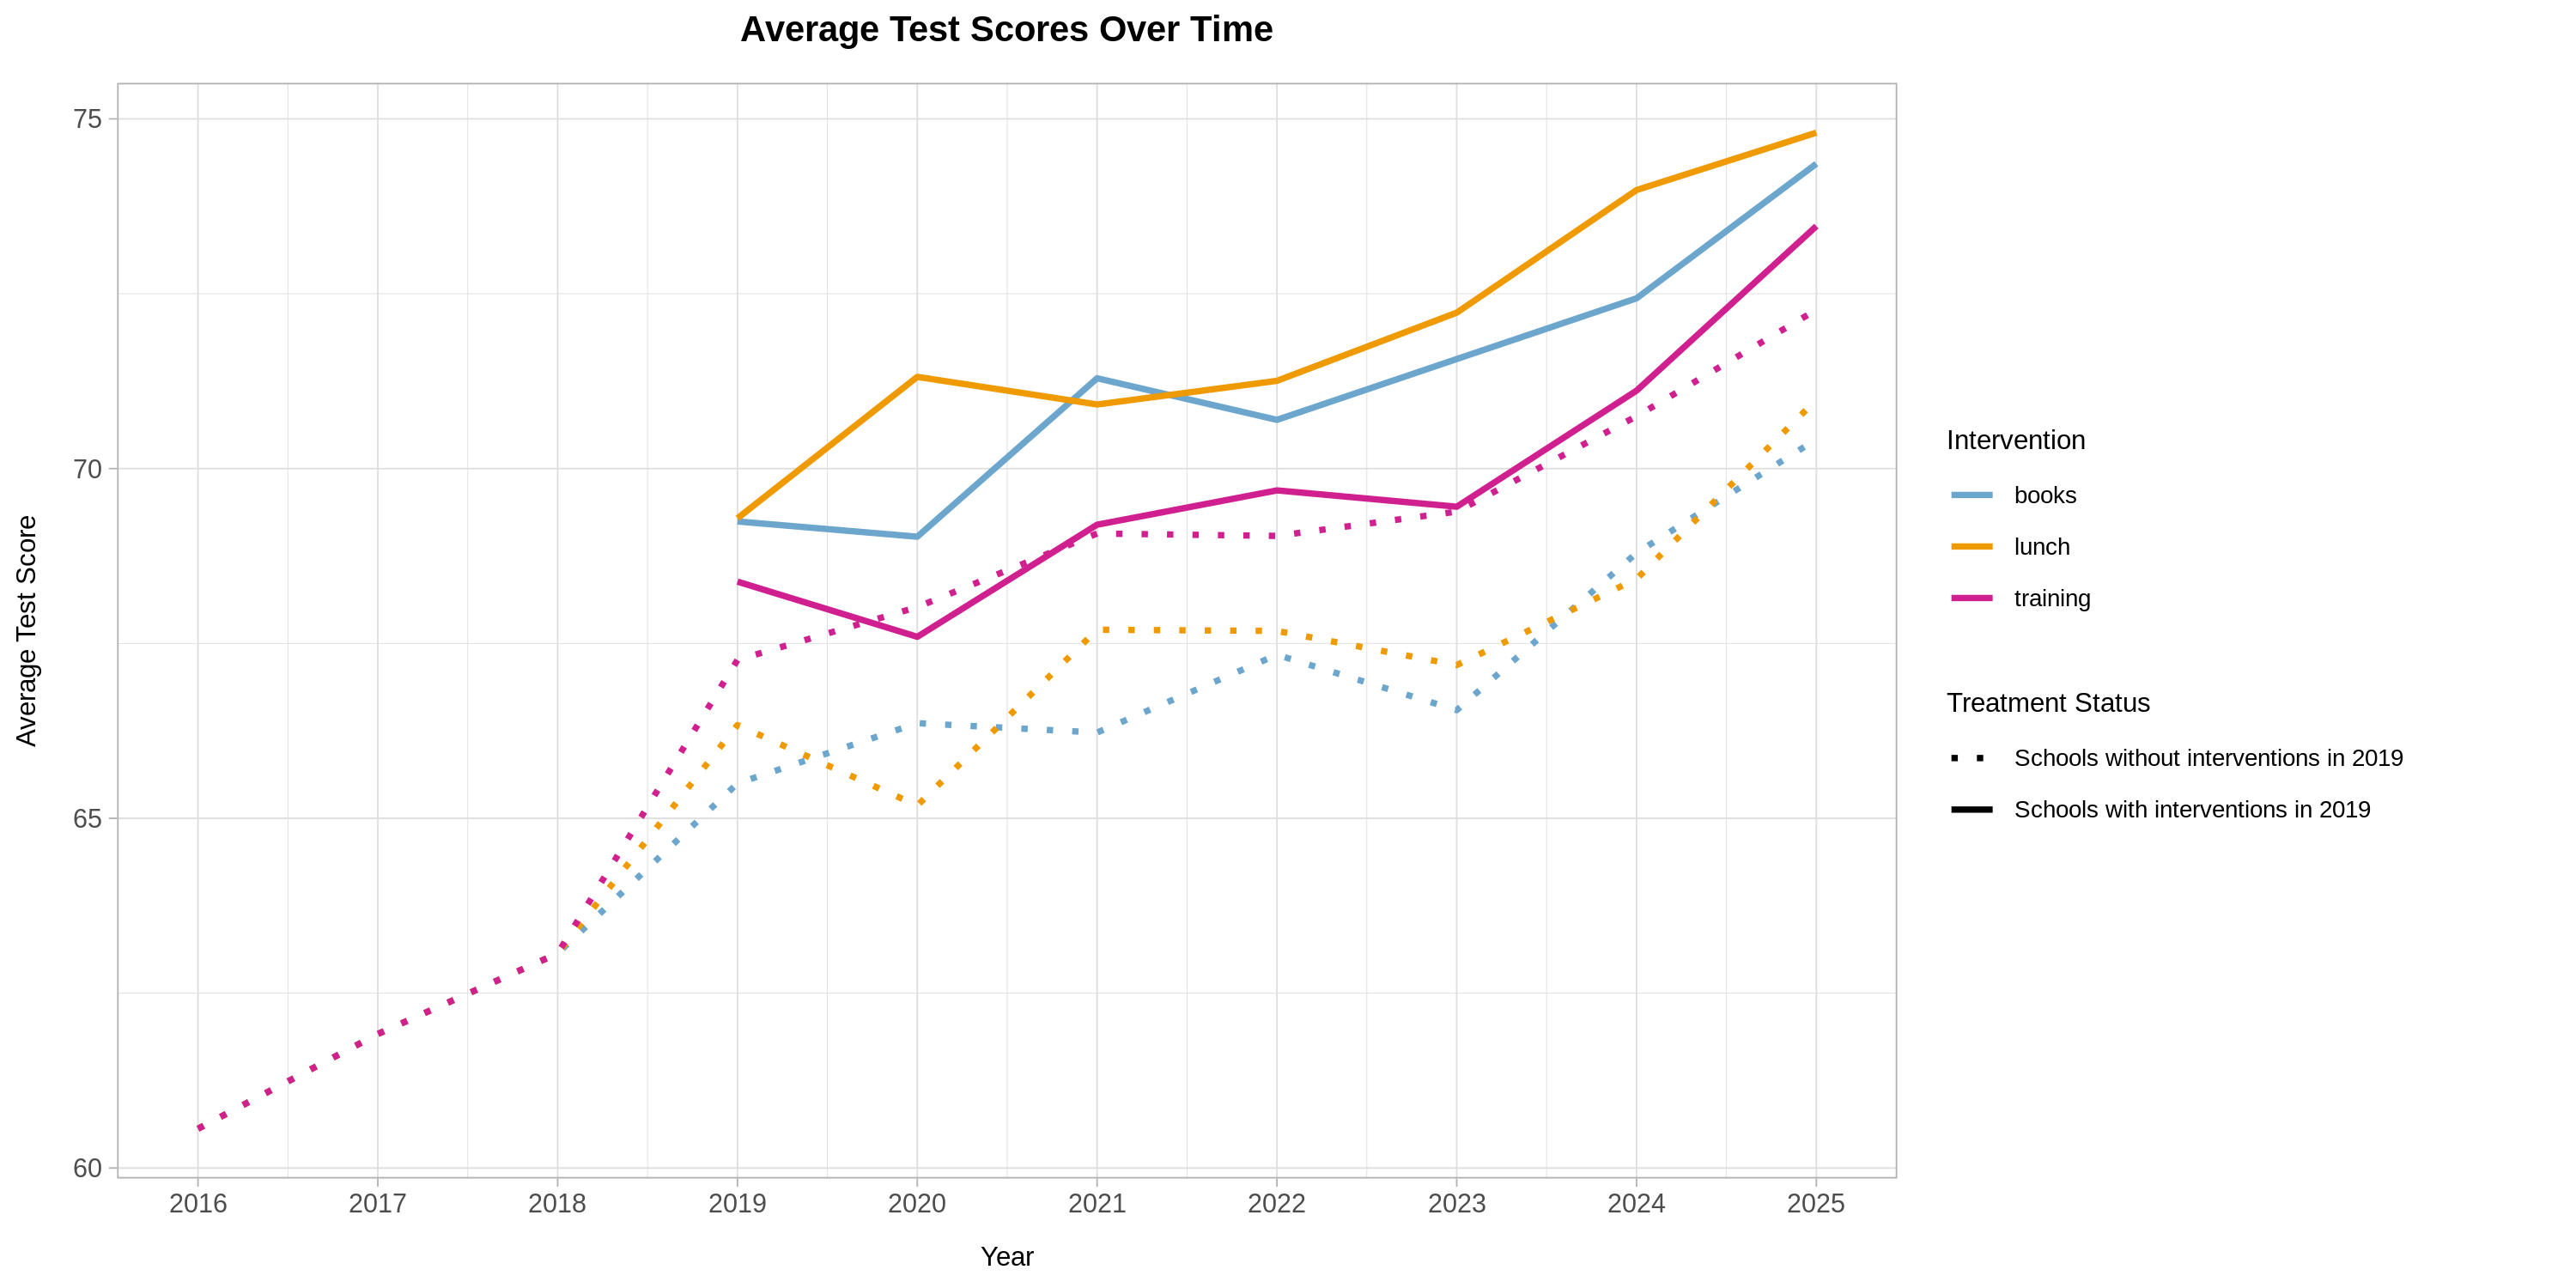

In [35]:
# Combine data on pre/post trends for all interventions

trend_all <- schools |>
  pivot_longer(cols = c(books, training, lunch),
               names_to = "program",
               values_to = "treated") |>
  group_by(year, program, treated) |>
  summarise(mean_score = mean(test_score, na.rm = TRUE), .groups = "drop")

# Plot all three interventions to see surface-level effects
options(repr.plot.width=12, repr.plot.height=6, repr.plot.res = 250)
trend_all |>
  ggplot(aes(x = year, y = mean_score,
             color = program, linetype = factor(treated))) +
  geom_line(linewidth = 1) +
  scale_color_manual(
    values = c("books" = "skyblue3",
               "training" = "violetred",
               "lunch"    = "orange2")) +
  scale_linetype_manual(
    values = c("0" = "dotted", "1" = "solid"),
    labels = c("0" = "Schools without interventions in 2019",
               "1" = "Schools with interventions in 2019")) +
  scale_x_continuous(breaks = seq(2016, 2025, 1)) +
  labs(
    title     = "Average Test Scores Over Time",
    x = "Year", y = "Average Test Score",
    color     = "Intervention",
    linetype  = "Treatment Status") +
  theme_light() +
  theme(
    plot.title    = element_text(face = "bold", hjust = 0.5,
                                  margin = margin(b = 12), size = 12),
    plot.subtitle = element_text(face = "italic", hjust = 0.5,
                                  margin = margin(b = 12), size = 10),
    axis.title.x  = element_text(margin = margin(t = 10), size = 9),
    axis.title.y  = element_text(margin = margin(r = 10), size = 9),
    legend.title  = element_text(size = 9),
    legend.text   = element_text(size = 8),
    legend.position = "right")


### Notes
- The **lunch** intervention seems to have the most impact (as measured by improvements in average test scores), followed by the **books** intervention
- The dotted line for the **training** intervention (schools that did not receive the training intervention) seems to be higher than the dotted lines for the **books** or **lunch** treatments (schools that did not receive books or lunch interventions)
  - potentially skewed by **books** or **lunch** implemented  in schools that did not receive the **training** intervention
    - reinforces potentially higher impact of these interventions
- **Key Limitation**: trend lines for schools without a given intervention in 2019 (dotted lines) could still be biased by implementation of other interventions or by external disruptions and differences between schools

# Section 2: Casual Analysis and Cost-Effectiveness

## 2.1: Fixed-Effects Analysis

In [15]:
# Run fixed-effect OLS to quantify potential synergistic effects
# of interaction combinations, controlling for variations
# across schools and across years

m_impact <- schools |>
  feols(
    test_score ~ books*training*lunch | school_id + year,
  data = _,
  cluster = ~ school_id)

m_impact

OLS estimation, Dep. Var.: test_score
Observations: 1,000
Fixed-effects: school_id: 100,  year: 10
Standard-errors: Clustered (school_id) 
                      Estimate Std. Error   t value Pr(>|t|)    
books                 0.999215    1.58376  0.630911 0.529552    
training              1.545033    1.66681  0.926940 0.356212    
lunch                -0.132468    1.68905 -0.078428 0.937646    
books:training        2.499666    2.40691  1.038539 0.301549    
books:lunch           2.802496    2.08902  1.341536 0.182816    
training:lunch        3.701814    2.19367  1.687498 0.094656 .  
books:training:lunch -0.277029    3.23834 -0.085547 0.931999    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 4.85912     Adj. R2: 0.71359 
                Within R2: 0.064888

In [36]:
# Generate table of fixed-effect coefficients, including standard error

coef_tab <- tidy(m_impact, conf.int = TRUE) |>
  mutate(
    `Intervention` = case_when(
      term == "books"             ~ "Books (main effect)",
      term == "training"          ~ "Training (main effect)",
      term == "lunch"             ~ "Lunch (main effect)",
      term == "books:training"    ~ "Books × Training (interaction)",
      term == "books:lunch"       ~ "Books × Lunch (interaction)",
      term == "training:lunch"    ~ "Training × Lunch (interaction)",
      term == "books:training:lunch"   ~ "All three (interaction)",
      TRUE ~ term)) |>
  select(`Intervention`,
          `FE Coeff` = estimate,
           SE = std.error,
          `CI low` = conf.low,
          `CI high` = conf.high) |>
  arrange(factor(`Intervention`,
                 levels = c("Books (main effect)",
                            "Training (main effect)",
                            "Lunch (main effect)",
                            "Books × Training (interaction)",
                            "Books × Lunch (interaction)",
                            "Training × Lunch (interaction)",
                            "All three (interaction)")))

coef_tab
counts_2019 #to visualize number of schools implementing each intervention

Intervention,FE Coeff,SE,CI low,CI high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Books (main effect),0.9992151,1.583764,-2.1433172,4.141747
Training (main effect),1.5450325,1.666809,-1.7622784,4.852344
Lunch (main effect),-0.1324680,1.689049,-3.4839083,3.218972
Books × Training (interaction),2.4996656,2.406906,-2.2761576,7.275489
Books × Lunch (interaction),2.8024962,2.089021,-1.3425740,6.947566
Training × Lunch (interaction),3.7018141,2.193670,-0.6509033,8.054531
All three (interaction),-0.2770293,3.238336,-6.7025906,6.148532


combo,n
<chr>,<int>
Books only,30
Lunch only,19
Training only,15
Books + Lunch,14
Books + Training,7
All three,6
Training + Lunch,5
None,4


## 2.2: Visualizing FE Coefficients

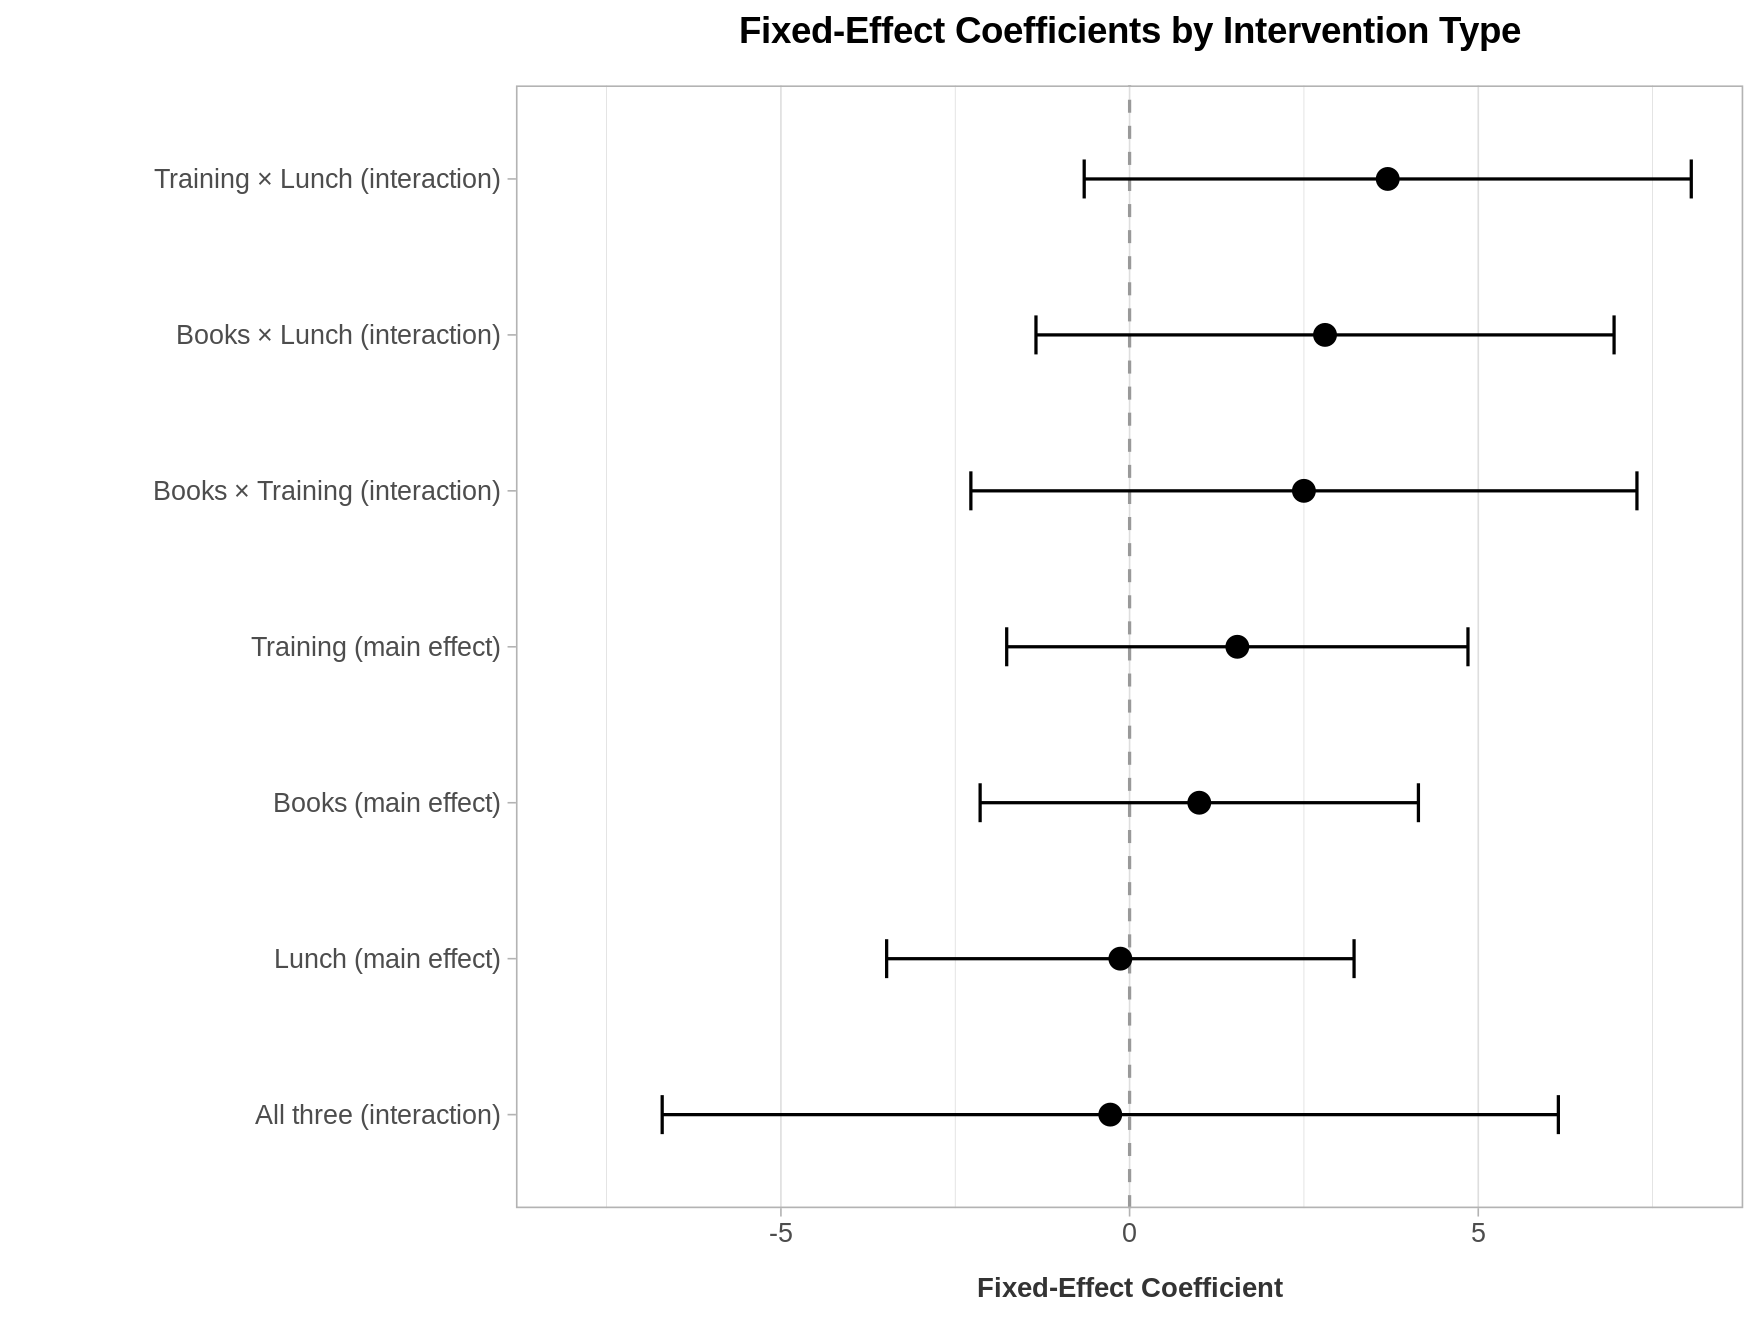

In [18]:
# Ordering by coefficient value to make the graph cleaner

coef_plot <- coef_tab |>
  mutate(Intervention = reorder(Intervention, `FE Coeff`))

# Vizualize coefficients + 95% confidence intervals

options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 220)
ggplot(coef_plot, aes(x = `FE Coeff`, y = Intervention,)) +
  geom_vline(xintercept = 0, color = "gray60", linetype = "dashed") +
  geom_point(size = 3) +
  geom_errorbar(aes(xmin = `CI low`, xmax = `CI high`),
                width = 0.25, orientation = "y") +
  coord_cartesian(xlim = c(-8, 8)) +
  labs(
    title = "Fixed-Effect Coefficients by Intervention Type",
    x     = "Fixed-Effect Coefficient",
    y     =  NULL) +
  theme_light(base_size = 11) +
  theme(
    plot.title    = element_text(face = "bold", hjust = 0.5,
                                  margin = margin(b = 12), size = 12),
    axis.title.x  = element_text(color = "#333333", margin = margin(t = 10),
                                  size = 9, face = "bold"),
    axis.title.y  = element_text(margin = margin(r = 10), size = 9),
    panel.grid.major.y = element_blank())

### Notes
- The coefficients for **Lunch** and **All Three** are negative
  - Likely reflects model limitations rather than a harmful effect given high SEs and wide CIs
- The **Training x Lunch** intervention shows the largest positive  coefficient
  - Suggests strong potential boost when implemented together
- **Training** intervention has the strongest coefficient for individual programs, followed by the **Books**
  - Largest direct effects on learning when run alone
- Standard Errors (SEs) are high compared to coefficients
  - High level of uncertainty — results are not conslusive/deterministic
- Confident Intervals (CIs) span zero — can't definitively rule out negative effects
  - Likely due to limited sample size for 2019

# Section 3: Evaluating Program Impacts and Cost-Efficacy

## 3.1: Determining Program Impact

In [19]:
# Import FE coefficients from prior section

getc <- function(nm) if (nm %in% names(coef(m_impact))) coef(m_impact)[[nm]] else 0

b   <- getc("books")
t   <- getc("training")
l   <- getc("lunch")
bt  <- getc("books:training")
bl  <- getc("books:lunch")
tl  <- getc("training:lunch")
btl <- getc("books:training:lunch")

# Create table of single intervention impact

single_effects <- tribble(
  ~Intervention,        ~effect_points,    ~kind,
  "Books",               b,                "Single",
  "Training",            t,                "Single",
  "Lunch",               l,                "Single")

# Create table of combined intervention impact (composite predictions)

combined_effects <- tribble(
  ~Intervention,        ~effect_points,                   ~kind,
  "Books + Training",    b + t + bt,                      "Bundled",
  "Books + Lunch",       b + l + bl,                      "Bundled",
  "Training + Lunch",    t + l + tl,                      "Bundled",
  "All three",           b + t + l + bt + bl + tl + btl, "Bundled")

effects_all <- bind_rows(single_effects, combined_effects)

effects_all

Intervention,effect_points,kind
<chr>,<dbl>,<chr>
Books,0.9992151,Single
Training,1.5450325,Single
Lunch,-0.1324680,Single
Books + Training,5.0439133,Bundled
Books + Lunch,3.6692432,Bundled
Training + Lunch,5.1143786,Bundled
All three,11.1387262,Bundled


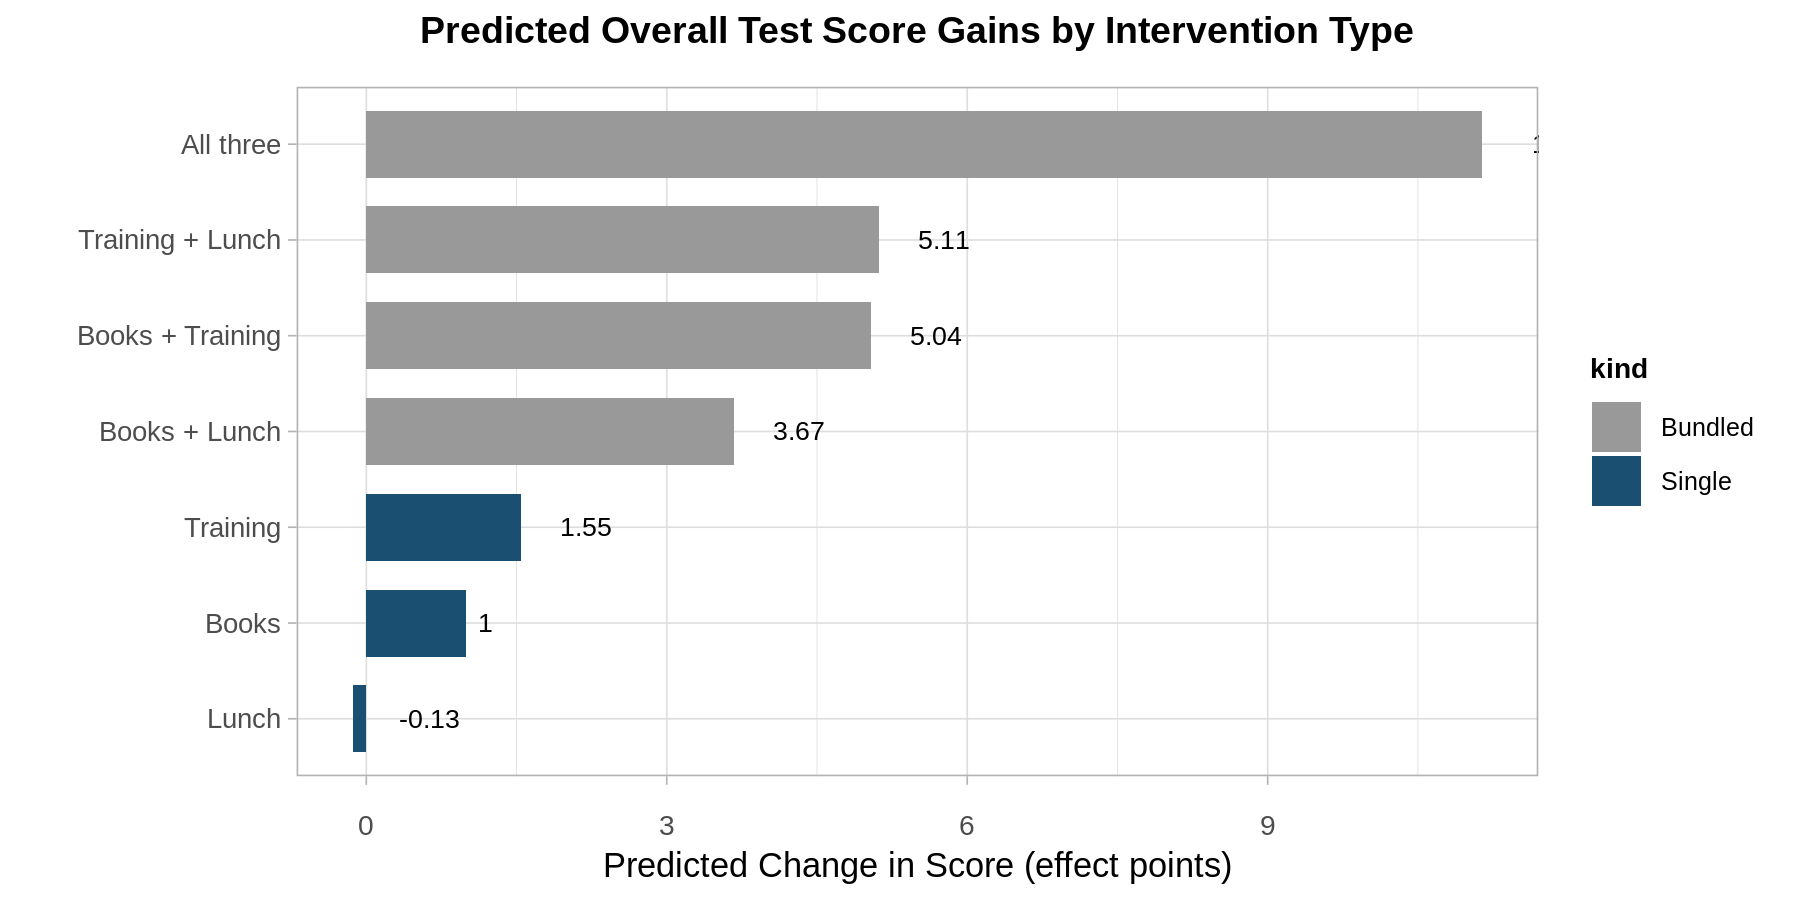

In [20]:
# Order by intervention impact to make graph cleaner

effects_plot <- effects_all |>
  mutate(Intervention = reorder(Intervention, effect_points))

# Visualize impact of each intervention

options(repr.plot.width = 8, repr.plot.height = 4, repr.plot.res = 225)

effects_plot |>
  ggplot(aes(x = Intervention, y = effect_points, fill = kind)) +
  geom_col(width = 0.7) +
  geom_text(aes(label = round(effect_points, 2)),
            hjust = -0.75, size = 3) +
  coord_flip() +
  scale_fill_manual(values = c("Single"="#1B4F72","Bundled"="#999999")) +
  labs(
    title = "Predicted Overall Test Score Gains by Intervention Type",
    x = NULL, y = "Predicted Change in Score (effect points)") +
  theme_light() +
  theme(
    plot.title      = element_text(face = "bold", hjust = 0.5,
                                  margin = margin(b = 12), size = 12),
    axis.text.x     = element_text(margin = margin(t = 10), size = 9),
    axis.title.y    = element_text(margin = margin(r = 10), size = 9),
    legend.position = "right",
    legend.title    = element_text(face = "bold", size = 9),
    legend.text     = element_text(size = 8))

## 3.2: Calculating Cost-Effectiveness

In [21]:
# Calculate average cost per student by intervention for the year 2019

avg_cost_2019 <- schools |>
  filter(year == 2019) |>
  mutate(Intervention = case_when(
    books==1 & training==0 & lunch==0 ~ "Books",
    books==0 & training==1 & lunch==0 ~ "Training",
    books==0 & training==0 & lunch==1 ~ "Lunch",
    books==1 & training==1 & lunch==0 ~ "Books + Training",
    books==1 & training==0 & lunch==1 ~ "Books + Lunch",
    books==0 & training==1 & lunch==1 ~ "Training + Lunch",
    books==1 & training==1 & lunch==1 ~ "All three",
    TRUE ~ NA_character_)) |>
  filter(!is.na(Intervention)) |>
  group_by(Intervention) |>
  summarise(
    avg_cost_student = mean(cost_per_student, na.rm = TRUE),
    n_schools_2019 = n_distinct(school_id),
    .groups = "drop")

avg_cost_2019

Intervention,avg_cost_student,n_schools_2019
<chr>,<dbl>,<int>
All three,225,6
Books,50,30
Books + Lunch,125,14
Books + Training,150,7
Lunch,75,19
Training,100,15
Training + Lunch,175,5


In [22]:
# Merge data on average cost per student and program impact into one table
# and calculate cost-effectiveness

ce_all_weighted <- effects_all |>
  left_join(avg_cost_2019, by = "Intervention") |>
  mutate(
    ce_pts_100 = 100 * effect_points / avg_cost_student) |>
  select(Intervention,
          effect_points,
          avg_cost_student,
          kind,
          ce_pts_100) |>
  filter(!is.na(ce_pts_100)) |>
  arrange(desc(ce_pts_100))

ce_all_weighted

Intervention,effect_points,avg_cost_student,kind,ce_pts_100
<chr>,<dbl>,<dbl>,<chr>,<dbl>
All three,11.1387262,225,Bundled,4.9505450
Books + Training,5.0439133,150,Bundled,3.3626088
Books + Lunch,3.6692432,125,Bundled,2.9353946
Training + Lunch,5.1143786,175,Bundled,2.9225020
Books,0.9992151,50,Single,1.9984302
Training,1.5450325,100,Single,1.5450325
Lunch,-0.1324680,75,Single,-0.1766241


## 3.3: Visualizing Cost-Effectiveness

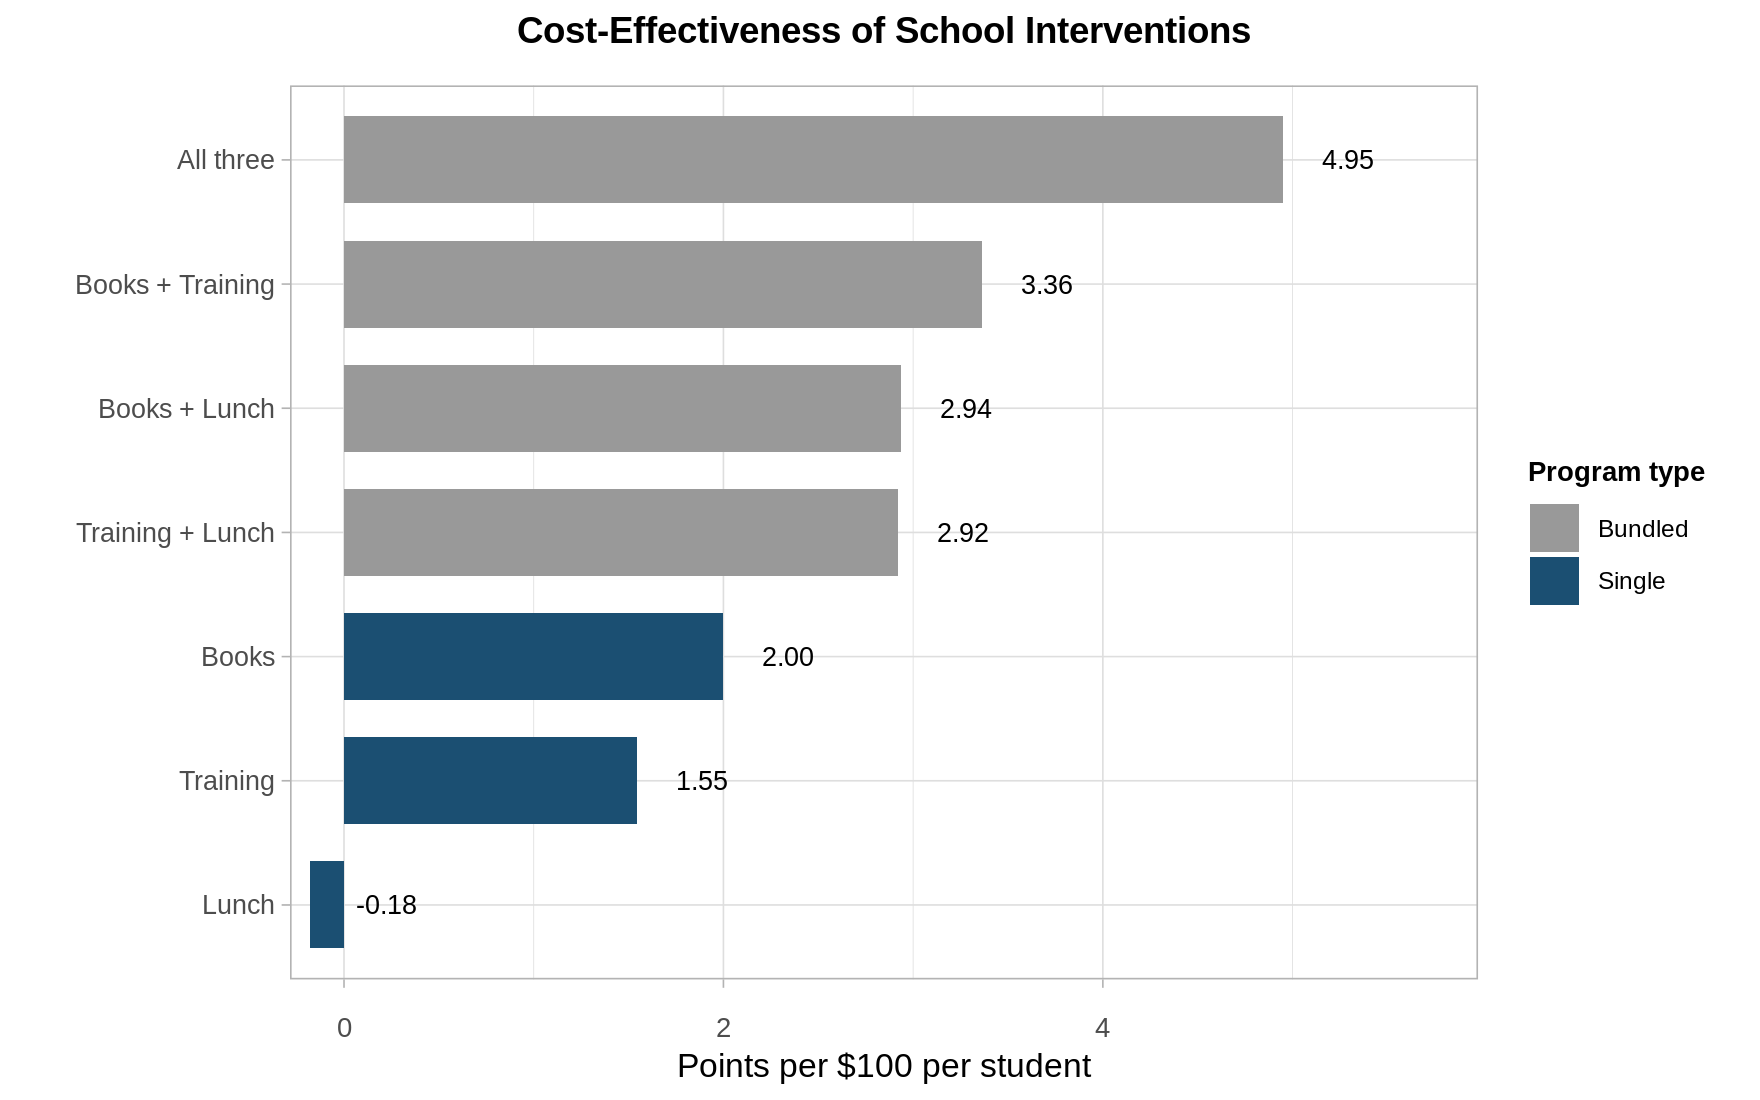

In [23]:
# Order interventions by descending cost-effectiveness

plot_data <- ce_all_weighted |>
  mutate(Intervention = factor(Intervention, levels = rev(Intervention)))

# Plot ordered bar chart

options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 220)

ggplot(plot_data, aes(x = Intervention, y = ce_pts_100, fill = kind)) +
  geom_col(width = 0.7) +
  geom_text(aes(label = number(ce_pts_100, accuracy = 0.01)),
                hjust = -0.75, size = 3.1) +
  coord_flip(ylim = c(0, max(plot_data$ce_pts_100, na.rm = TRUE) * 1.15)) +
  scale_fill_manual(values = c("Single" = "#1B4F72", "Bundled" = "#999999"),
                    name = "Program type") +
  labs(
    title = "Cost-Effectiveness of School Interventions",
    x = NULL,
    y = "Points per $100 per student") +
  theme_light() +
  theme(
    plot.title      = element_text(face = "bold", hjust = 0.5,
                                  margin = margin(b = 12), size = 12),
    axis.text.x     = element_text(margin = margin(t = 10), size = 9),
    axis.title.y    = element_text(margin = margin(r = 10), size = 9),
    legend.position = "right",
    legend.title    = element_text(face = "bold", size = 9),
    legend.text     = element_text(size = 8))

### Notes
- Program impact (`effect_points`) considers composite sums of relevant FE coefficients for combined interventions, rather than just the marginal boost/drop from synergistic interactions
  - Program impact for independent interventions matched FE coefficients
- Cost-effectiveness is highest when bundling all three interventions and lowest for the independetly implemented **Lunch** intervention
  - For bundles of two, **Books+Training** intervention is the second most cost-effective at the *third* highest cost

# Recommendations:

Given cost-efficacy calculations made above, I recommend the following:

- **Scenario 1: Flexible Budget**: implement *Books* AND *Training* for near-optimal results without the complexities of implementing three programs at once
  - Expected to increase average school-level test scores by ~3 points for each $100 in per-student spending
  - ~5 point total increase in overall predicted impact

  - Estimated cost per student: $150

- **Scenario 2: Stricter Budget**: implement the *Books* intervention if the new school has a more stringent budget
  - Most affordable option and most cost-effective among single interventions
  - Expected to increase average school-level test scores by ~2 points for each $100 in per-student spending
    - ~1 point increase in overall predicted gain (since cost/student is less than $100)
    
  - Estimated cost per student: $50

